# 잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)

# Google Fonts

In [1]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

Selecting previously unselected package fonts-nanum.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


['NanumBarunGothic'] 11.0


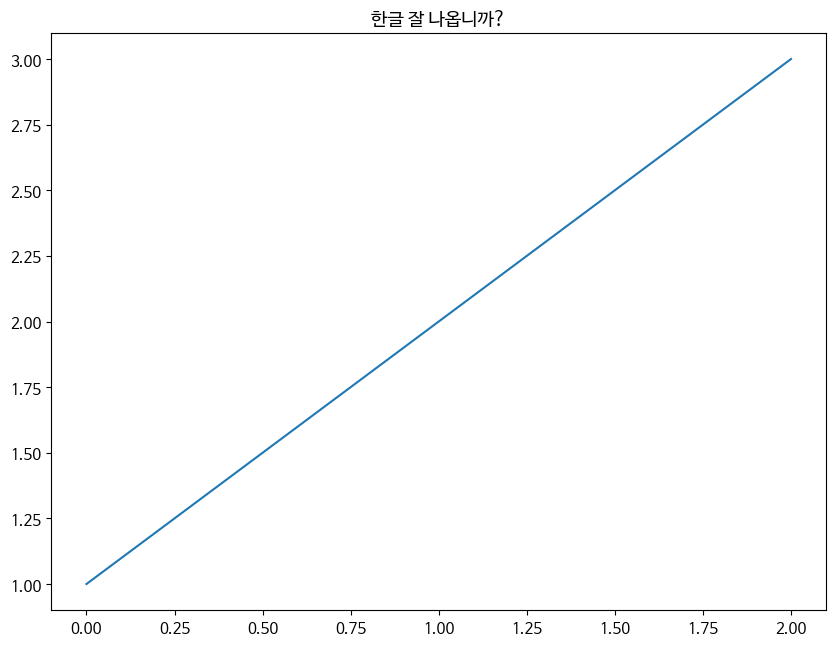

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# Google Drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Colab용 notebook입니다. 이 notebook 한 장에서 여러 데이터의 다운로드부터, 추천까지 완결하도록 되어 있습니다(예측 평가는 미포함)
# MovieLens 데이터를 아직 다운로드 하지 않았다면, 이 셀을 실행해서 다운로드합니다.
# MovieLens 데이터 분석은 data_download.ipynb를 참조합니다.

# 데이터 다운로드와 압축 풀기
!wget -nc --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-10m.zip -P ../data
!unzip -n ../data/ml-10m.zip -d ../data/

--2024-12-10 05:59:43--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘../data/ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M  60.6MB/s    in 1.0s    

2024-12-10 05:59:45 (60.6 MB/s) - ‘../data/ml-10m.zip’ saved [65566137/65566137]

Archive:  ../data/ml-10m.zip
   creating: ../data/ml-10M100K/
  inflating: ../data/ml-10M100K/allbut.pl  
  inflating: ../data/ml-10M100K/movies.dat  
  inflating: ../data/ml-10M100K/ratings.dat  
  inflating: ../data/ml-10M100K/README.html  
  inflating: ../data/ml-10M100K/split_ratings.sh  
  inflating: ../data/ml-10M100K/tags.dat  


In [5]:
# 부모 폴더의 경로 추가
# import sys; sys.path.insert(0, '..')

import sys
# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/2024/알파코/recommend_system/2025_codes/')

from util.data_loader import DataLoader
from util.metric_calculator import MetricCalculator

In [6]:
# Movielens 데이터 로딩
data_loader = DataLoader(num_users=1000, num_test_items=5, data_path='../data/ml-10M100K/')
movielens = data_loader.load()

In [7]:
import gensim
import logging
from gensim.corpora.dictionary import Dictionary

movie_content = movielens.item_content.copy()
# tag가 부여되어 있지 않은 영화도 있지만, genre는 모든 영화에 부여되어 있다
# tag와 genre를 결합한 것을 영화 콘텐츠 정보로 해서 비슷한 영화를 찾아 추천한다
# tag가 없는 영화는 NaN으로 되어 있으므로, 빈 리스트로 변환한 뒤 처리한다
movie_content['tag_genre'] = movie_content['tag'].fillna("").apply(list) + movie_content['genre'].apply(list)
movie_content['tag_genre'] = movie_content['tag_genre'].apply(lambda x:list(map(str, x)))

# 태그와 장르 데이터를 사용해 LDA를 학습한다
tag_genre_data = movie_content.tag_genre.tolist()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
common_dictionary = Dictionary(tag_genre_data)
common_corpus = [common_dictionary.doc2bow(text) for text in tag_genre_data]

# LDA 학습
lda_model = gensim.models.LdaModel(common_corpus, id2word=common_dictionary, num_topics=50, passes=30)
lda_topics = lda_model[common_corpus]

In [8]:
# LDAContent추천
from src.lda_content import LDAContentRecommender
recommender = LDAContentRecommender()
recommend_result = recommender.recommend(movielens)

In [9]:
# 평가
metric_calculator = MetricCalculator()
metrics = metric_calculator.calc(
    movielens.test.rating.tolist(), recommend_result.rating.tolist(),
    movielens.test_user2items, recommend_result.user2items, k=10)
print(metrics)

rmse=0.000, Precision@K=0.004, Recall@K=0.014
